# Parametric psychophysics curves

Plotting, per layer, the decodability of generative stimulus features across a particular parametric feature. Just used to explore the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

def fix_bytes(df):

    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.replace("b'", '').str.replace("'", '')

    return df

In [2]:
model = 'ResNet6'
dataset = 'gmf_112x112_emo'
target_ = 'id'
epoch = '050'

perf_var = 'id'
layernames = [f'L{i+1}' for i in range(6)]
paths = sorted(list(Path('../results').glob(f'{model}_dataset-{dataset}_target-{target_}_epoch-{epoch}_layer-*_preds.csv')))

factors = [
    #'emo', 'gender', 'ethn', 'age', 
    'xr', 'yr', 'zr', 'xt', 'yt', 'zt', 'xl', 'yl', 'shape', 'tex'
]
cat_factors = ['emo', 'gender', 'ethn', 'id']
xlabels = [
    #'Emotion', 'Gender', 'Ethnicity', 'Age',
    'Rotation (X)', 'Rotation (Y)', 'Rotation (Z)', 'Translation (X)', 'Translation (Y)', 'Translation (Z)', 'Light (X)', 'Light (Y)', '3D shape', 'Texture'
]

Layer: layer06, factor: xr:  86%|████████▌ | 60/70 [13:52<00:56,  5.67s/it]   

IndexError: list index out of range

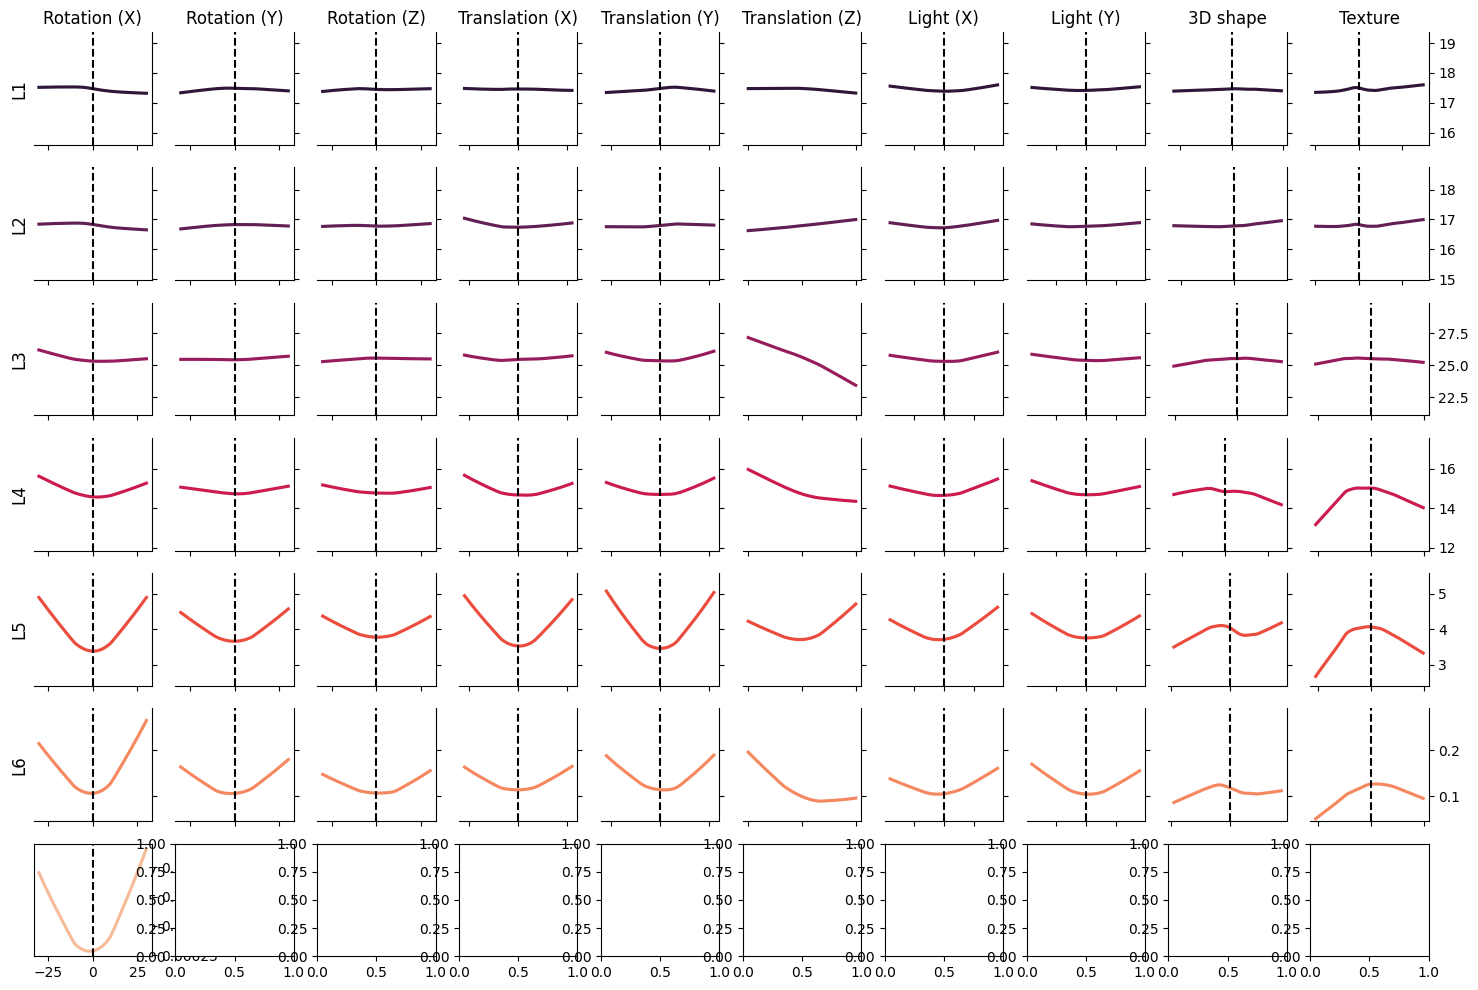

In [3]:
perf_var = 'id'  # any feature name, or 'specific', in which case the target is the factor itself

fig, axes = plt.subplots(nrows=len(paths), ncols=len(factors), figsize=(18, 12))
pbar = tqdm(total=len(paths) * len(factors))
cmap = sns.color_palette("rocket", n_colors=len(paths))

# Loop over layers
for i, path in enumerate(paths):
    df = fix_bytes(pd.read_csv(path))
    layer = path.stem.split('layer-')[1].split('_')[0]
    
    # Used to set the y-axis limits (same for all features within a layer)
    y_min, y_max = np.inf, -np.inf

    # Loop over factors to show parametric curves for
    for ii, factor in enumerate(factors):
        pbar.set_description(f'Layer: {layer}, factor: {factor}')
        ax = axes[i, ii]

        if perf_var == 'specific':
            target = factor
        else:
            target = perf_var

        if target in cat_factors:
            # Negative log likelihood of true class (if categorical)
            df['y_pred'] = -np.log(df[f'{target}_truepred'])
        else:
            # Root squared error (if continuous)
            df['y_pred'] = np.sqrt((df[target] - df[f'{target}_pred'])**2)

        if factor in cat_factors:
            sns.barplot(x=factor, y='y_pred', data=df, ax=ax, estimator='mean')
            ax_values = ax.containers[0].datavalues
        else:
            sns.regplot(x=factor, y='y_pred', data=df, x_ci=None, scatter=False, lowess=True, ax=ax, line_kws={'color': cmap[i]})        
            ax_values = ax.lines[0].get_ydata()

        # Update y-axis limits
        if ax_values.min() < y_min:
            y_min = ax_values.min()
    
        if ax_values.max() > y_max:
            y_max = ax_values.max()

        ax.yaxis.tick_right()
        ax.set_ylabel('')
        ax.set_xlabel('')
        
        if factor not in cat_factors + ['zt', 'age']:
            # Show reference at feature = 0
            ax.axvline(0., ls='--', color='k')

        if factor in cat_factors:
            labels = [item.get_text() for item in ax.get_xticklabels()]
            ax.set_xticklabels(labels, rotation=90)

        if ii == 0:
            ax.set_ylabel(layernames[i], fontsize=12)

        if ii != len(factors) - 1:
            ax.set_yticklabels([])

        if i == 0:
            ax.set_title(xlabels[ii], fontsize=12)

        if i != len(paths) - 1:
            ax.set_xticklabels([])

        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)

        pbar.update(1)

    # Set y-axis limits
    for ii in range(len(factors)):
        if factors[ii] not in cat_factors:
            axes[i, ii].set_ylim(y_min * 0.9, y_max * 1.1)

fig.text(0.92, 0.5, 'Negative log likelihood', va='center', rotation='vertical', fontsize=20)
fig.savefig('./figures/psychophysics.pdf')